In [1]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
%matplotlib notebook


# parser_data_directory should be set to the data-directory which the blocksci_parser output
chain = blocksci.Blockchain("/blocksci/bitcoin.json")

In [2]:
# of inputs in aggregation : 18 – 25
# only one output (aggregated to)
# Amount of bitcoin in the big wallet: 15 to 100 (majority)
# Time between input transaction and the aggregation transaction: 1 hour
# Time between aggregation transaction and it being spent: 1 hour

def input_count(tx):
    # ** tx is a TxProxy type, so all of its fields are also proxy, like 
    # tx.input_count is an intProxy that cannot be compared to an int like
    # 18. **
    
    return (tx.input_count >= 1 and tx.input_count <= 25) 
    
    # aggregated addresses were received within an hour
    
#     for addr in tx.inputs:
#         if (addr.block_t)


In [3]:
def output_count(tx):
    #     print('2')
#     print(tx.output_count)
    return (tx.output_count == 1)

In [13]:
def output_value(tx):
    #     print('3')
#     print(tx.output_value/1e8)
#     val = tx.output_value/1e8
    return (tx.output_value >= 0 and tx.output_value <= 20000000000)

In [14]:
def output_spent(tx):
#     print('4')
    output = tx.outputs[0]
#     print(output)
    return output.is_spent

In [15]:
def time_till_spent(tx):
#     print('5')
    # spent within an hour
    output = tx.outputs[0]
    time = tx.block_time # datetimeProxy
    print(time) # this is type datetime.datetimeProxy
    print(output.spending_tx) # this is type OptionalTxProxy
    
    x = tx.outputs[0].spending_tx.any(lambda inpt: inpt.age <= 9)
    print(x)
    
    print(output.spending_tx.block_time) 
    print('hello')
    delta = output.spending_tx.block_time - time
    print(delta)
    return delta <= timedelta(minutes=90)



In [16]:
# this is my comparison function that returns a boolProxy, because it's used in 'where'
def is_BTC_e(tx):
    return input_count(tx) & output_count(tx) & output_value(tx) & output_spent(tx) 
# & time_till_spent(tx)
#     return is_BTC_e(tx) & ~tx.is_coinbase

In [17]:
# testing on known transactions 
true = chain.tx_with_hash("c3377cc8f0f6002d5a1bd5e58e7676b495909a789e382577f5e9e09c364d1c89")
false = chain.tx_with_hash("2b20ae522e360c64b61a852bb0294ed7a16b5623a47c11919921917546ac0734")

In [18]:
print(is_BTC_e(true))
print("...")
# cast 'true to a txProxy, which is what happens when we run where - so if this works 
# correctly, then where will work.
print(is_BTC_e(blocksci.proxy.TxProxy(true)))

True
...


In [19]:
print(is_BTC_e(blocksci.proxy.TxProxy(false)))
print(false.index)

339783916


In [20]:
# this is my comparison function that returns a boolProxy, because it's used in 'where'
def select_BTC_e(tx):
#     return blocksci.proxy.boolProxy(is_BTC_e(tx)) & ~tx.is_coinbase
    return is_BTC_e(tx) & ~tx.is_coinbase

In [12]:
# the range of blocks where 1Fs had transactions
btc_e_matches = chain[311793:478781].txes.where(select_BTC_e)

len = sum(1 for _ in btc_e_matches)
print(len)

24873749


In [269]:
print(sum(chain[311793:478781].tx_count))

200618657


In [21]:
# for the whole blockchain

btc_e_matches_all_blockchain = chain[-557101:].txes.where(select_BTC_e)

len = sum(1 for _ in btc_e_matches_all_blockchain)
print(len)


39489504


In [273]:
print(sum(chain[-557101:].tx_count))

362436386


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


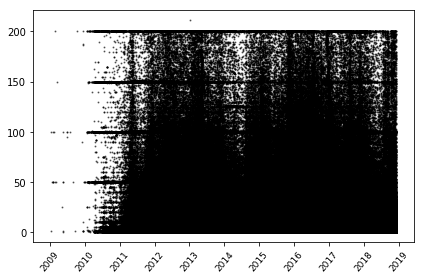

In [22]:
# plot transaction volume over time.
# we have a list of the transactions
btc_e_matches_all_blockchain_inputs = chain[-557101:].txes.where(select_BTC_e).input_value
btc_e_matches_all_blockchain_times = chain[-557101:].txes.where(select_BTC_e).block_time
# btc_e_matches_all_blockchain_inputs = btc_e_matches_all_blockchain.input_value
# btc_e_matches_all_blockchain_times = btc_e_matches_all_blockchain.block_time

%time inputs = btc_e_matches_all_blockchain_inputs
times = btc_e_matches_all_blockchain_times

# df = pd.DataFrame({"Inputs":inputs/1e8}, index=times)
# ax = df.resample("d").mean().plot()
# ax.set_ylim(0)
# plt.plot()

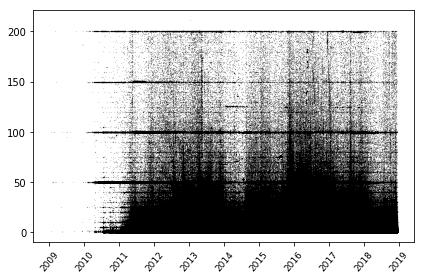

In [26]:
# the amounts aggregated over time
x = times
y = inputs

colors =(0,0,0)
area = 0.01 # 0 to 15 point radii

plt.scatter(x, y/1e8, s=area, c=colors, alpha=0.5)
# plt.ylim(0, 200)

plt.tick_params(axis='x', which='major', labelsize=9, rotation=50)
plt.tight_layout()
plt.savefig('graph1.svg', format='svg', dpi=1200)

[]

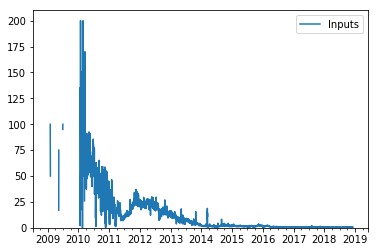

In [24]:
# the mean amounts aggregated over time
df = pd.DataFrame({"Inputs":inputs/1e8}, index=times)
ax = df.resample("d").mean().plot()
# ax.set_ylim(0)
plt.plot()
plt.savefig('graph2.svg', format='svg', dpi=1200)

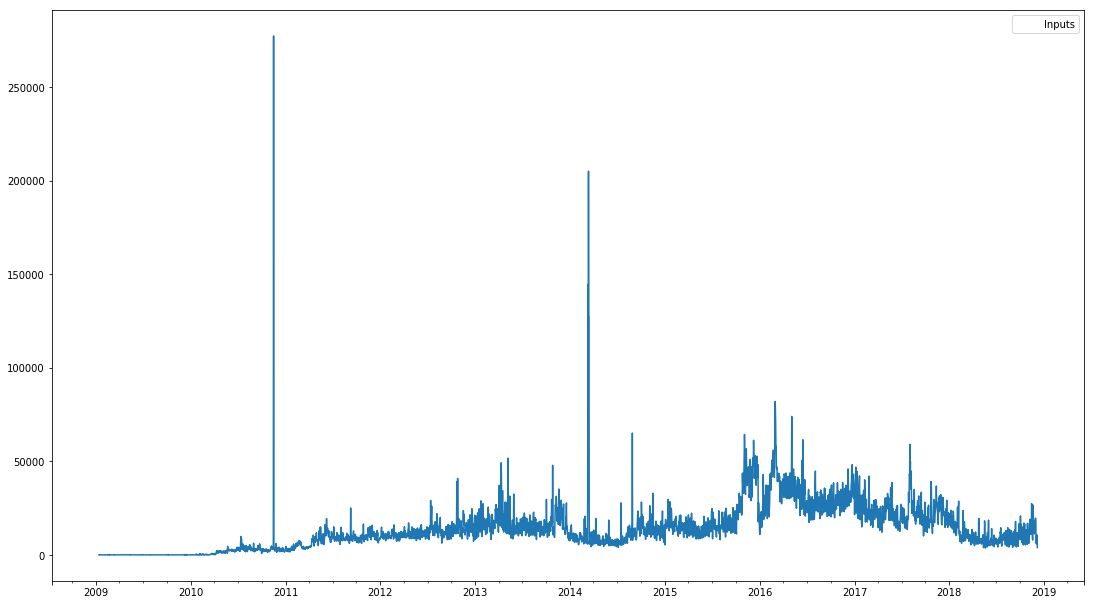

In [30]:
df = pd.DataFrame({"Inputs":inputs/1e8}, index=times)
ax = df.resample("d").sum().plot()
# ax.set_ylim(0, 50000)
plt.plot()

leg = plt.legend()

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(0.01)


    
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)



plt.savefig('graph3.svg', format='svg', dpi=1200)


In [ ]:
# plot this but for # of transactions...

In [21]:
# run on all 1Fs transactions...
address = chain.address_from_string("1FsVcdeHbpvUVT3gjeuVR2ZSDnpcsJMsLL")

print(address.in_txes_count() + address.out_txes_count()) # returns a list of transactions

# the transactions where 1Fs is the output
allOutTx = address.out_txes
allAggIns = address.out_txes.input_value

print(sum(allAggIns)/1e8) # total amount of BTC deposited into 1Fs

# allAggIns.hi
mean = np.mean(allAggIns)
print(mean/1e8) # the mean amount aggregated

30379
658062.14505987
41.694363876314384


15091
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


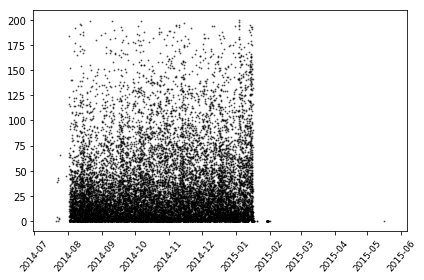

In [32]:
address = chain.address_from_string("1FsVcdeHbpvUVT3gjeuVR2ZSDnpcsJMsLL")

# i want to run "where" on the list of 1Fs transactions
btc_e_matches_1Fs_inputs = address.out_txes.where(select_BTC_e).input_value
btc_e_matches_1Fs_times = address.out_txes.where(select_BTC_e).block_time
# print(btc_e_matches_1Fs.to_list())

len = sum(1 for _ in btc_e_matches_1Fs_inputs)
print(len) 
# # 14038 matches

# print(address.out_txes_count())

# matches 14038/15783 of the 1Fs aggregation transactions

# now graph this
%time inputs = btc_e_matches_1Fs_inputs
times = btc_e_matches_1Fs_times

# df = pd.DataFrame({"Amounts aggregated":inputs/1e8}, index=times)
# ax = df.resample("d").sum().plot()
# ax.set_ylim(0)
# plt.plot()

x = times
y = inputs

colors =(0,0,0)
area = 1 # 0 to 15 point radii

plt.scatter(x, y/1e8, s=area, c=colors, alpha=0.5)
# plt.ylim(0, 200)

plt.tick_params(axis='x', which='major', labelsize=9, rotation=50)
plt.tight_layout()

plt.savefig('graph4.svg', format='svg', dpi=1200)


In [66]:
address = chain.address_from_string("1PaQ8CjmkWvWXvG7GnMLv6zsCBsh5QMVdr")

# i want to run "where" on the list of 1Fs transactions
btc_e_matches_1Fs_inputs = address.out_txes.where(select_BTC_e).input_value
btc_e_matches_1Fs_times = address.out_txes.where(select_BTC_e).block_time

len = sum(1 for _ in btc_e_matches_1Fs_inputs)
print(len) 

print(address.out_txes_count())

45
4526


In [33]:
# given all BTC-e addresses, find the transactions where money is deposited into BTC-e 
# from outside. these are all the BTC-e aggregation transactions... then run the heuristic
# on those. and it should return high

# or, given all BTC-e transactions, how many are aggregation transactions?

import csv

num_of_matches = 0 
num_total = 0

matchrate_by_tx_num = {}

with open('addresses_above_5.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            address = chain.address_from_string(row[0])
            allOutTx = address.out_txes
            
            matches_for_addr = allOutTx.where(select_BTC_e)
        
            len = sum(1 for _ in matches_for_addr)
            num_of_matches += len
            
            num_total += address.out_txes_count()
            
            tx_num = address.out_txes_count()
            
            line_count += 1
            
            matchrate = len * 100 / tx_num
            
            if (tx_num not in matchrate_by_tx_num):
                matchrate_by_tx_num[tx_num] = [matchrate]
            else: # it is already there, so recalculate the average
                matchrate_by_tx_num[tx_num].append(matchrate)
            
    print(line_count)
    print(num_of_matches) # totals
    print(num_total)
#     print(matchrate_by_tx_num)

151677
408640
3506719


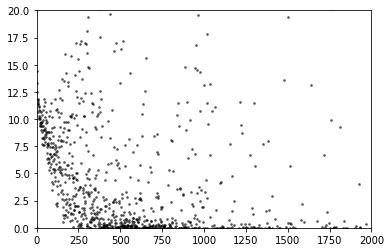

In [43]:
# now graph this
# go through matchrate_by_tx_num, and change each list to the respective average:
for num_tx, list_of_matchrates in matchrate_by_tx_num.items():
    matchrate_by_tx_num[num_tx] = np.mean(list_of_matchrates)

lists = sorted(matchrate_by_tx_num.items())
x_data, y_data = zip(*lists)

colors =(0,0,0)
area = 3  # 0 to 15 point radii

plt.scatter(x_data, y_data, s=area, c=colors, alpha=0.5)
plt.xlim(0, 2000)
# plt.ylim(0, 20)

a, b = np.polyfit(np.log(x), y, 1)

# def graph(formula, x_range):  
#     x = np.array(x_range)  
#     y = eval(formula)
#     plt.plot(x, y)  
#     plt.show()

# graph('x**3+2*x-4', range(-10, 11))

plt.savefig('graph6.jpeg', format='jpeg', dpi=1200)
plt.show()


array([ 2.05950941, -4.21512168])

[2.05950896 0.12916533]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


TypeError: 'numpy.float64' object cannot be interpreted as an integer

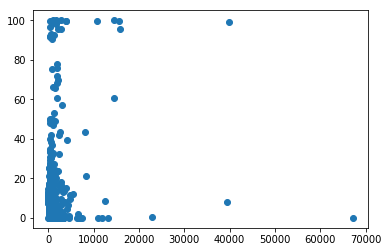

In [41]:
from scipy import optimize

def test_func(x, a, b):
    return a * np.log(b * x)

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 2])

print(params)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')

plt.show()

In [ ]:
# to graph:
# num of matches/num transactions (what percentage is aggregation transactions, 
# per num of transactions) per # transactions 
    
buckets = {}

# Initializing all dates to zero
for date in allDates:
    buckets[date] = 0

for tx in allTx:
    truncatedDate = "{year}-{month}".format(year=tx.block_time.year, month=tx.block_time.month)
    buckets[str(truncatedDate)] += 1
        
lists = sorted(buckets.items())

x, y = zip(*lists)

plt.plot(x,y)
plt.tick_params(axis='x', which='major', labelsize=2)
plt.show()
